# Initiate And Create Comet Experiment

In [1]:
%%capture
# Create an experiment comet_ml experiment
!pip install --upgrade comet_ml --quiet

In [2]:
# initiate comet
import json

from comet_ml.api import API
from comet_ml import Experiment

path_to_auth_file = '/content/drive/MyDrive/Colab Notebooks/_auth/comet.json'
with open(path_to_auth_file) as json_file:
    data = json.load(json_file)    

In [3]:
# Track the experiment
with open(path_to_auth_file) as json_file:
    data = json.load(json_file)
    experiment = Experiment(
        api_key=data['api_key'],
        project_name=data['project_name'],
        workspace=data['workspace'],
        log_code=True,
        auto_histogram_tensorboard_logging=True,
        auto_histogram_weight_logging=True,
        auto_histogram_gradient_logging=True,
        auto_histogram_activation_logging=True,
    )
    experiment.add_tag('GradCam_Ensemble')

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/saschamet/master-thesis/5b50b23def4d47e291004183fcbd0d44



# Setup

In [4]:
!pip install -q efficientnet

     |████████████████████████████████| 51kB 2.9MB/s 


In [5]:
import re
import os
import sys
import glob
import math
import json
import random
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from pathlib import Path
from sklearn import metrics
from functools import partial
from joblib import dump, load
import matplotlib.pyplot as plt
import efficientnet.tfkeras as efn
from datetime import datetime, date
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, auc, classification_report

In [6]:
# Global Settings
SEED = 42
DIM = 384
EPOCHS = 30
NUM_CLASSES = 1
BATCH_SIZE = 32
VERBOSE_LEVEL = 1
SAVE_OUTPUT = True

# The 2019 Data may decrease the model performance. More Infos here: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/168028 
EXCLUDE_2019 = True

In [7]:
# cleanup
for f in glob.glob("/content/*.png"):
    os.remove(f)

for f in glob.glob("/content/*.hdf5"):
    os.remove(f)

for f in glob.glob("/content/*.txt"):
    os.remove(f)

for f in glob.glob("/content/*.h5"):
    os.remove(f)

for f in glob.glob("/content/*.json"):
    os.remove(f)

!rm -rf logs

In [8]:
%%capture
!rm -rf /content/melanoma-classification
!rm -rf /content/sample_data/

# if we do not have the data
if not os.path.exists("/content/melanoma-classification/README.md"):
    # install kaggle
    !pip install kaggle

    # get kaggle auth file
    path_to_auth_file = "kaggle.json"
    if not os.path.exists(path_to_auth_file):
        path_to_auth_file = '/content/drive/MyDrive/Colab Notebooks/_auth/kaggle.json'

    # read the kaggle.json file
    with open(path_to_auth_file) as json_file:
        data = json.load(json_file)
        os.environ['KAGGLE_USERNAME'] = data["username"]
        os.environ['KAGGLE_KEY'] = data["key"]

    # remove sample data so we have more space
    !rm -rf /content/sample_data

    ## pull repo
    !git clone https://github.com/SaschaMet/melanoma-classification.git

    ## update repo
    !cd melanoma-classification && git fetch && git pull

    ## switch branch and execute function
    !cd /content/melanoma-classification && git checkout "master" && git fetch && git reset --hard origin/master

In [9]:
# make sure the repo ist added to the sys path
sys.path.insert(0,'/content/melanoma-classification')
sys.path.insert(1,'/content/melanoma-classification/src')

In [10]:
# Set needed env variables based on the global variables
os.environ["DIM"] = str(DIM)
os.environ["BATCH_SIZE"] = str(BATCH_SIZE)

# seed everything
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# get the current timestamp. This timestamp is used to save the model data with a unique name
now = datetime.now()
today = date.today()
current_time = now.strftime("%H:%M:%S")
timestamp = str(today) + "_" + str(current_time)

# environment settings
print("Tensorflow version " + tf.__version__)
REPLICAS = 1
AUTOTUNE = tf.data.AUTOTUNE

Tensorflow version 2.5.0


In [11]:
%load_ext autoreload
%autoreload 2

# Custom imports
from plots.plot_auc import plot_auc
from plots.plot_confusion_matrix import plot_confusion_matrix
from plots.display_batch_of_images import display_batch_of_images
from model.clr_callback import cyclic_learning_rate, get_lr_callback, plot_clr
from model.evaluation import evaluate_model, predict_on_dataset, pred_to_binary, calc_f1

In [12]:
## prevent colab shutdown 
%%javascript
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}

var connection = setInterval(ConnectButton, 60000);

function myStopFunction() {
    console.log("Remove interal"); 
    clearInterval(connection);
}

<IPython.core.display.Javascript object>

# Data Loading & Preparation

## Loading

In [13]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [116]:
df_train = pd.read_csv('/content/melanoma-classification/data/train.csv')
df_test = pd.read_csv('/content/melanoma-classification/data/test.csv')

In [15]:
# Datasets used: https://www.kaggle.com/cdeotte/melanoma-384x384 & https://www.kaggle.com/cdeotte/isic2019-384x384
GCS_PATH_2020 = 'gs://kds-a9944322ba317510b2a67208005e962f54e25d613a823927a1e5daeb'
GCS_PATH_OLD = 'gs://kds-76c4b8da4c24f1d4c37711d5a6d340a98763d093eb2a60ebbaa107f2'

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH_2020 + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH_2020 + '/test*.tfrec')

print("# TRAINING_FILENAMES", len(TRAINING_FILENAMES))
print("# TEST_FILENAMES", len(TEST_FILENAMES))

# TRAINING_FILENAMES 15
# TEST_FILENAMES 16


In [16]:
OLD_COMP_FILENAMES = tf.io.gfile.glob(GCS_PATH_OLD + '/*.tfrec')
print("# OLD_COMP_FILENAMES", len(OLD_COMP_FILENAMES))

# OLD_COMP_FILENAMES 30


In [17]:
OLD_COMP_FILENAMES_TMP = []
if EXCLUDE_2019:
     for i in range(0, len(OLD_COMP_FILENAMES), 2):
         OLD_COMP_FILENAMES_TMP.append(OLD_COMP_FILENAMES[i])

     OLD_COMP_FILENAMES = OLD_COMP_FILENAMES_TMP
     print("# OLD_COMP_FILENAMES", len(OLD_COMP_FILENAMES))

# OLD_COMP_FILENAMES 15


In [18]:
# Only use data from 2020 for validation 
TRAINING_FILENAMES, VALIDATION_FILENAMES = train_test_split(TRAINING_FILENAMES, test_size = 0.20, random_state = SEED)
TRAINING_FILENAMES = list(TRAINING_FILENAMES) + list(OLD_COMP_FILENAMES)

random.shuffle(TRAINING_FILENAMES)
random.shuffle(VALIDATION_FILENAMES)

In [19]:
for x in TRAINING_FILENAMES:
    if x in VALIDATION_FILENAMES:
        raise Exception("TRAIN AND TEST FILES ARE NOT VALID!")

In [20]:
print("# TRAINING_FILENAMES", len(TRAINING_FILENAMES))
print("# VALIDATION_FILENAMES", len(VALIDATION_FILENAMES))

TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)

print("# TRAINING_IMAGES", TRAINING_IMAGES)
print("# VALIDATION_IMAGES", VALIDATION_IMAGES)

# TRAINING_FILENAMES 27
# VALIDATION_FILENAMES 3
# TRAINING_IMAGES 39015
# VALIDATION_IMAGES 6536


In [21]:
# Get the class weights and the inital bias
benign_cases = df_train['benign_malignant'].value_counts().benign
malignant_cases = df_train['benign_malignant'].value_counts().malignant

initial_bias = np.log([malignant_cases/benign_cases])

print("initial_bias", initial_bias)

initial_bias [-4.02038586]


## Preparation

In [23]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
resizing_layer = tf.keras.layers.experimental.preprocessing.Resizing(DIM, DIM)

In [22]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    return image

In [24]:
def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    idnum = example['image_name']
    return image, idnum

In [25]:
def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.cache() # cache ds for performance gains
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)

    # normalize the image so the values are between 0 and 1
    dataset = dataset.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE) 
    
    # resize the images to the same height and width
    dataset = dataset.map(lambda x, y: (resizing_layer(x), y), num_parallel_calls=AUTOTUNE) 

    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

In [26]:
def get_training_dataset(files=TRAINING_FILENAMES, augment=True, shuffle=True):
    dataset = load_dataset(files, labeled=True)
    if augment:
        dataset = dataset.map(lambda x, y: (augment_image(x, augment=augment), y), num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    
    if shuffle: 
        dataset = dataset.shuffle(1024 * REPLICAS, reshuffle_each_iteration=True)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        dataset = dataset.with_options(opt)
    
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [27]:
def get_validation_dataset(files=VALIDATION_FILENAMES, ordered=False, repeat=False):
    dataset = load_dataset(files, labeled=True, ordered=ordered)
    if repeat:
        dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [28]:
def get_test_dataset(ordered=True):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [29]:
def prepare_df(df):
    df_prep = df.copy()
    feature_columns = ['age_approx', 'sex_female', 'sex_male', 'anatom_head/neck',
        'anatom_lower extremity', 'anatom_oral/genital', 'anatom_palms/soles',
        'anatom_torso', 'anatom_upper extremity']

    # getting dummy variables for gender
    sex_dummies = pd.get_dummies(df_prep['sex'], prefix='sex', dtype="int")
    df_prep = pd.concat([df_prep, sex_dummies], axis=1)

    # getting dummy variables for anatom_site_general_challenge
    anatom_dummies = pd.get_dummies(df_prep['anatom_site_general_challenge'], prefix='anatom', dtype="int")
    df_prep = pd.concat([df_prep, anatom_dummies], axis=1)

    # convert age to int
    mean_age = df_prep["age_approx"].mean()
    df_prep['age_approx'] = df_prep['age_approx'].fillna(mean_age)
    df_prep['age_approx'] = df_prep['age_approx'].astype('int')

    # dropping not useful columns
    df_prep.drop(['sex','anatom_site_general_challenge', 'patient_id'], axis=1, inplace=True)

    df_prep = df_prep[feature_columns]

    return df_prep

# Data Validation

In [30]:
example_dataset = get_training_dataset(files=TRAINING_FILENAMES, augment=False)
example_dataset = example_dataset.unbatch().batch(15)

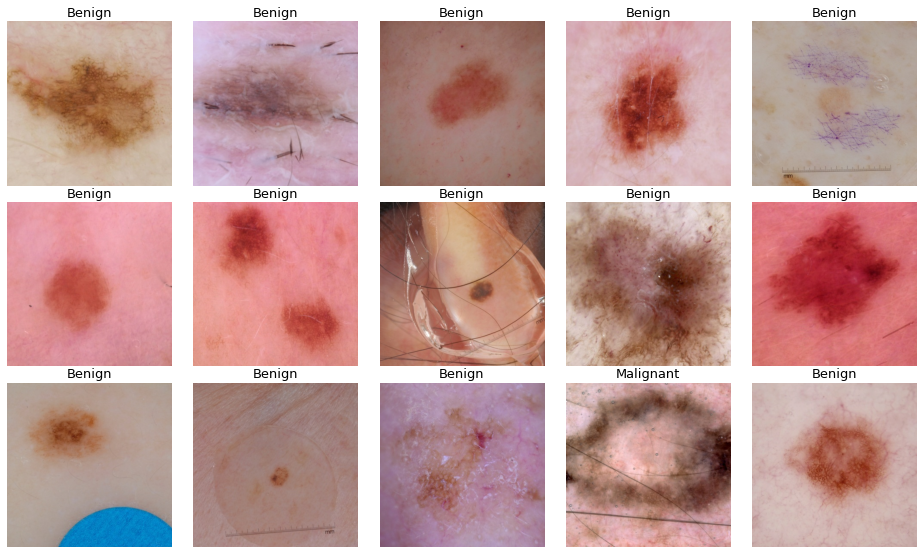

In [31]:
example_batch = iter(example_dataset) 
image_batch, label_batch = next(example_batch)
images = [(x) for x in image_batch]
labels = [l.numpy() for l in label_batch]
display_batch_of_images((images, labels), unbatched=True)

In [32]:
for i in range(10):
    image = image_batch[i]
    print("min:", np.min(image), " -  max:", np.max(image))

print(image.dtype)

min: 0.03137255  -  max: 0.854902
min: 0.1137255  -  max: 0.94117653
min: 0.12941177  -  max: 0.6784314
min: 0.023529414  -  max: 0.9058824
min: 0.0  -  max: 0.882353
min: 0.21568629  -  max: 1.0
min: 0.10980393  -  max: 1.0
min: 0.0627451  -  max: 1.0
min: 0.0  -  max: 1.0
min: 0.0  -  max: 0.97647065
<dtype: 'float32'>


# Download Models

In [3]:
path_to_auth_file = '/content/drive/MyDrive/Colab Notebooks/_auth/comet.json'
with open(path_to_auth_file) as json_file:
    data = json.load(json_file)   
comet_api = API(data['api_key'])
# fetch all experiments
experiments = comet_api.get_experiments('saschamet')

In [29]:
# The .h5 file of every model is saved in the comet.ml project 
# and every model has a curl download link.

curls = []
for x in experiments:
    exp_tags = x.get_tags()
    model = x.get_model_asset_list('model.h5')

    # check if the experiment has a model file
    if model and model[0]:
        model = model[0]

        # Get the model name
        model_name = ""
        for x in exp_tags:
            if not "ROC" in x:
                model_name = x

        curl_download_link = model['curlDownload']

        # Get the curl download link and add the correct model name
        curl = curl_download_link.replace("model", model_name.replace(' ', ''))
        curls.append(" " + curl)    

In [30]:
curls

[' curl "https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?experimentKey=11bb9a95915e4bd9a53c7067682abc5a&assetId=ce4f3b3beb044e85a71a2ca7df99fd49" -H"Authorization: F9fl5tr7uO4QZDhfOL286dJvJ" > effnetB6-SEED42.h5',
 ' curl "https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?experimentKey=0ddf9ec380cf42cfa6fd03a706c8e68a&assetId=d5c39d10b92f48a59ec0fe3c7a4bce6c" -H"Authorization: F9fl5tr7uO4QZDhfOL286dJvJ" > resnet.h5',
 ' curl "https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?experimentKey=53e0c5951aa3433dbb63115d7bcf0fba&assetId=8183ab4576214916b8189401c9f1c872" -H"Authorization: F9fl5tr7uO4QZDhfOL286dJvJ" > xception.h5',
 ' curl "https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?experimentKey=4f70bc5964794900a1b9e9e1b4206c7e&assetId=71dc9a8b63084e76b7f69b3ac3c8de74" -H"Authorization: F9fl5tr7uO4QZDhfOL286dJvJ" > effnetB6-SEED0.h5',
 ' curl "https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?experimentKey=04339dae5a0f4e4695089353237a12

In [38]:
# Now we can download the model files
for curl in tqdm(curls):
    os.system(curl)

100%|██████████| 8/8 [02:30<00:00, 18.76s/it]


In [39]:
!ls -sh -l

total 3.3G
4.0K drwx------  5 root root 4.0K Jun  9 08:04 drive
328M -rw-r--r--  1 root root 328M Jun  9 08:06 effnetB5-SEED0.h5
328M -rw-r--r--  1 root root 328M Jun  9 08:08 effnetB5-SEED21.h5
328M -rw-r--r--  1 root root 328M Jun  9 08:06 effnetB5-SEED42.h5
470M -rw-r--r--  1 root root 470M Jun  9 08:06 effnetB6-Seed0.h5
470M -rw-r--r--  1 root root 470M Jun  9 08:07 effnetB6-Seed21.h5
470M -rw-r--r--  1 root root 470M Jun  9 08:08 effnetB6-Seed42.h5
735M -rw-r--r--  1 root root 735M Jun  9 08:07 effnetB7.h5
4.0K drwxr-xr-x 11 root root 4.0K Jun  9 08:04 melanoma-classification
240M -rw-r--r--  1 root root 240M Jun  9 08:06 xception.h5


# Model Initialization

In [40]:
test_dataset = get_test_dataset(ordered=True)
num_test_images = count_data_items(TEST_FILENAMES)

test_dataset_images = test_dataset.map(lambda image, image_name: image)
test_dataset_image_name = test_dataset.map(lambda image, image_name: image_name).unbatch()
test_ids = next(iter(test_dataset_image_name.batch(num_test_images))).numpy().astype('U')

In [41]:
# CNNs
model = tf.keras.models.load_model('/content/effnetB5-SEED42.h5')
model_b6 = tf.keras.models.load_model('/content/effnetB6-Seed21.h5')

In [42]:
# Random forest classifier
%%capture
meta_model = load("/content/melanoma-classification/data/rf_model.joblib")

# Grad-Cam
Source: https://keras.io/examples/vision/grad_cam & https://arxiv.org/abs/1610.02391

## B5

In [43]:
%%capture
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/6/6c/Melanoma.jpg/512px-Melanoma.jpg

In [44]:
# Get the CNNs output layer
efficientnet_model = False
for layer in model.layers:
    if layer.name == "efficientnet-b5":
        efficientnet_model = layer

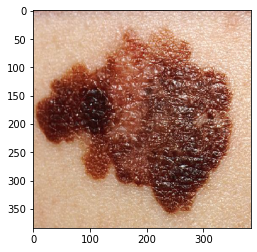

In [45]:
IMAGE_PATH = "/content/512px-Melanoma.jpg"
img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(DIM, DIM))
plt.imshow(img)
origin_img = img

In [46]:
# Get the prediction for the image from the model
prediction = model.predict(np.expand_dims(img, axis=0))
binary_prediction = [0 if x < 0.5 else 1 for x in prediction]
print("Prediction: " + ("Benign" if binary_prediction == 0 else "Malignant"))

Prediction: Malignant


In [47]:
prediction

array([[1.]], dtype=float32)

In [48]:
# First, we create a model that maps the input image to the activations
# of the last conv layer as well as the output predictions
grad_model = tf.keras.models.Model(
    [efficientnet_model.inputs], [efficientnet_model.get_layer('top_conv').output, efficientnet_model.output]
)

# Then, we compute the gradient of the top predicted class for our input image
# with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(np.expand_dims(img, axis=0))
    class_channel = preds[:, round(np.mean(tf.argmax(preds[0]).numpy()))]

# This is the gradient of the output neuron (top predicted or chosen)
# with regard to the output feature map of the last conv layer
grads = tape.gradient(class_channel, last_conv_layer_output)

# This is a vector where each entry is the mean intensity of the gradient
# over a specific feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the top predicted class
# then sum all the channels to obtain the heatmap class activation
last_conv_layer_output = last_conv_layer_output[0]
heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# For visualization purpose, we will also normalize the heatmap between 0 & 1
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap = heatmap.numpy()

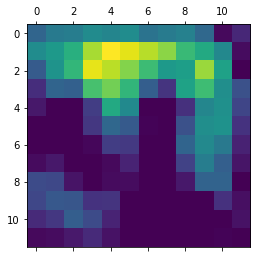

In [49]:
# Display heatmap
plt.matshow(heatmap)
plt.show()

In [50]:
import matplotlib.cm as cm

# Load the original image
o_img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(512, 512))

# Rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# Use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# Create an image with RGB colorized heatmap
jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((512,512))
jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + o_img
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

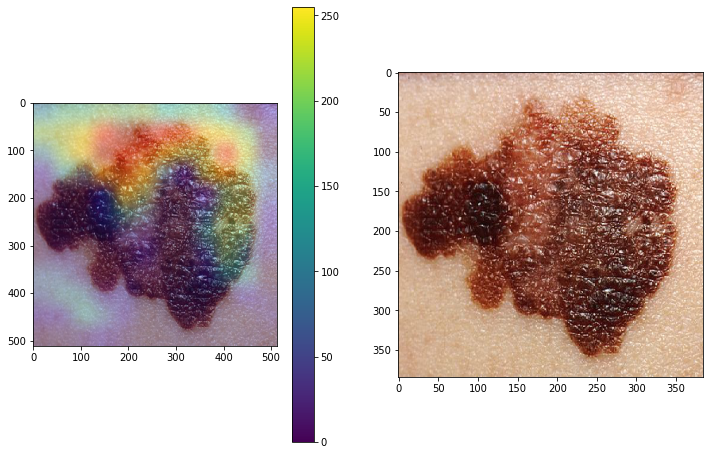

In [51]:
fig = plt.figure(figsize = (12, 8))

ax1 = fig.add_subplot(1, 2, 1)
ax1 = ax1.imshow(superimposed_img)
fig.colorbar(ax1)

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(origin_img)

plt.savefig(timestamp + '-grad_cam.png')

## B6

In [52]:
# Get the CNNs output layer
efficientnet_model = False
for layer in model_b6.layers:
    if layer.name == "efficientnet-b6":
        efficientnet_model = layer

In [53]:
prediction = model_b6.predict(np.expand_dims(img, axis=0))
binary_prediction = [0 if x < 0.5 else 1 for x in prediction]
print("Prediction: " + ("Benign" if binary_prediction == 0 else "Malignant"))

Prediction: Malignant


In [54]:
# First, we create a model that maps the input image to the activations
# of the last conv layer as well as the output predictions
grad_model = tf.keras.models.Model(
    [efficientnet_model.inputs], [efficientnet_model.get_layer('top_conv').output, efficientnet_model.output]
)

# Then, we compute the gradient of the top predicted class for our input image
# with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(np.expand_dims(img, axis=0))
    class_channel = preds[:, round(np.mean(tf.argmax(preds[0]).numpy()))]

# This is the gradient of the output neuron (top predicted or chosen)
# with regard to the output feature map of the last conv layer
grads = tape.gradient(class_channel, last_conv_layer_output)

# This is a vector where each entry is the mean intensity of the gradient
# over a specific feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the top predicted class
# then sum all the channels to obtain the heatmap class activation
last_conv_layer_output = last_conv_layer_output[0]
heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# For visualization purpose, we will also normalize the heatmap between 0 & 1
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap = heatmap.numpy()

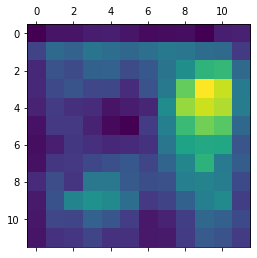

In [55]:
plt.matshow(heatmap)
plt.show()

In [56]:
# Load the original image
o_img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(512, 512))

# Rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# Use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# Create an image with RGB colorized heatmap
jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((512,512))
jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + o_img
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

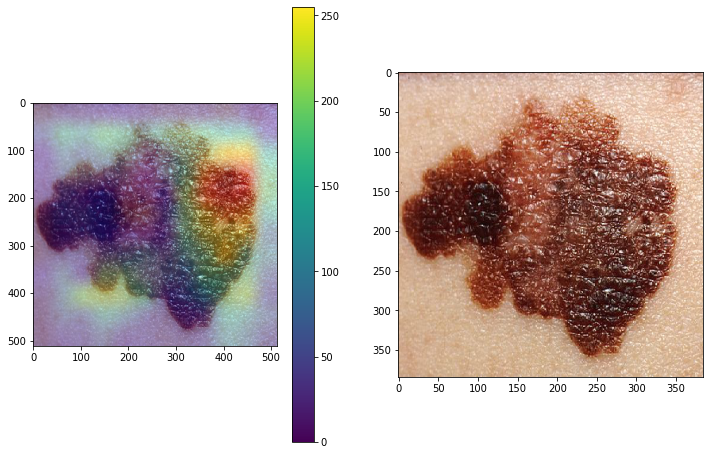

In [57]:
fig = plt.figure(figsize = (12, 8))

ax1 = fig.add_subplot(1, 2, 1)
ax1 = ax1.imshow(superimposed_img)
fig.colorbar(ax1)

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(origin_img)

plt.savefig(timestamp + '-grad_cam.png')

# Analyze Misclassified Images

## B5

In [58]:
NUM_IMAGES = 10000 # count_data_items(TRAINING_FILENAMES)
misclassified_analysis_ds = get_validation_dataset(files=TRAINING_FILENAMES, repeat=False, ordered=True).unbatch().take(NUM_IMAGES).batch(BATCH_SIZE)

In [59]:
misclassified_images = []
misclassified_predictions = []
misclassified_images_true_labels = []

for i, (img_batch, label_batch) in enumerate(tqdm(misclassified_analysis_ds, total=round(NUM_IMAGES / BATCH_SIZE))):
    predictions = model.predict(img_batch, verbose=0, use_multiprocessing=True)
    binary_predictions = [0 if x < 0.5 else 1 for x in predictions]

    labels = label_batch.numpy()

    for i, label in enumerate(labels):
        if label != binary_predictions[i]:
            misclassified_images.append(img_batch[i].numpy())
            misclassified_images_true_labels.append(label)
            misclassified_predictions.append(predictions[i])

313it [02:22,  2.19it/s]


In [60]:
print("Total misclassified", len(misclassified_images_true_labels))
print("Misclassified malignant images", sum(misclassified_images_true_labels))

Total misclassified 288
Misclassified malignant images 177


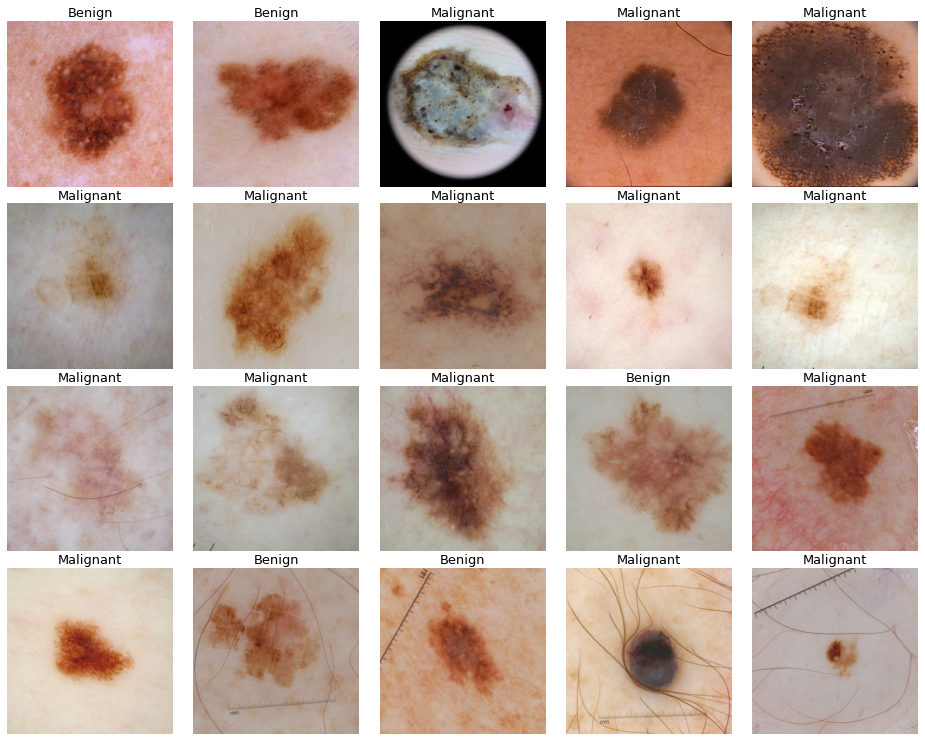

In [61]:
imgs_to_show = 20
display_batch_of_images((misclassified_images[0:imgs_to_show], misclassified_images_true_labels[0:imgs_to_show]), unbatched=True)

Max 0.9266
Min 0.0257
Median 0.3763
Total misclassified 288
Misclassified malignant images 177
 


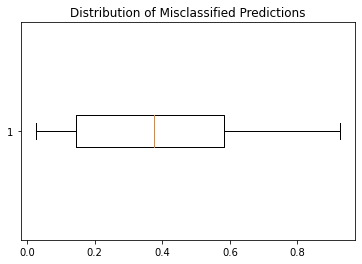

In [62]:
x = [x[0] for x in misclassified_predictions]
print("Max", round(np.max(x), 4))
print("Min", round(np.min(x), 4))
print("Median", round(np.median(x), 4))

print("Total misclassified", len(misclassified_images_true_labels))
print("Misclassified malignant images", sum(misclassified_images_true_labels))

print(" ")
_, ax1 = plt.subplots()
ax1.set_title('Distribution of Misclassified Predictions')
_ = ax1.boxplot(x, vert=False,)
plt.savefig(timestamp + '-misclassified_distribution.png')

## B6

In [63]:
misclassified_images = []
misclassified_predictions = []
misclassified_images_true_labels = []

for i, (img_batch, label_batch) in enumerate(tqdm(misclassified_analysis_ds, total=round(NUM_IMAGES / BATCH_SIZE))):
    predictions = model_b6.predict(img_batch, verbose=0, use_multiprocessing=True)
    binary_predictions = [0 if x < 0.5 else 1 for x in predictions]

    labels = label_batch.numpy()

    for i, label in enumerate(labels):
        if label != binary_predictions[i]:
            misclassified_images.append(img_batch[i].numpy())
            misclassified_images_true_labels.append(label)
            misclassified_predictions.append(predictions[i])

313it [02:55,  1.78it/s]


In [64]:
print("Total misclassified", len(misclassified_images_true_labels))
print("Misclassified malignant images", sum(misclassified_images_true_labels))

Total misclassified 340
Misclassified malignant images 279


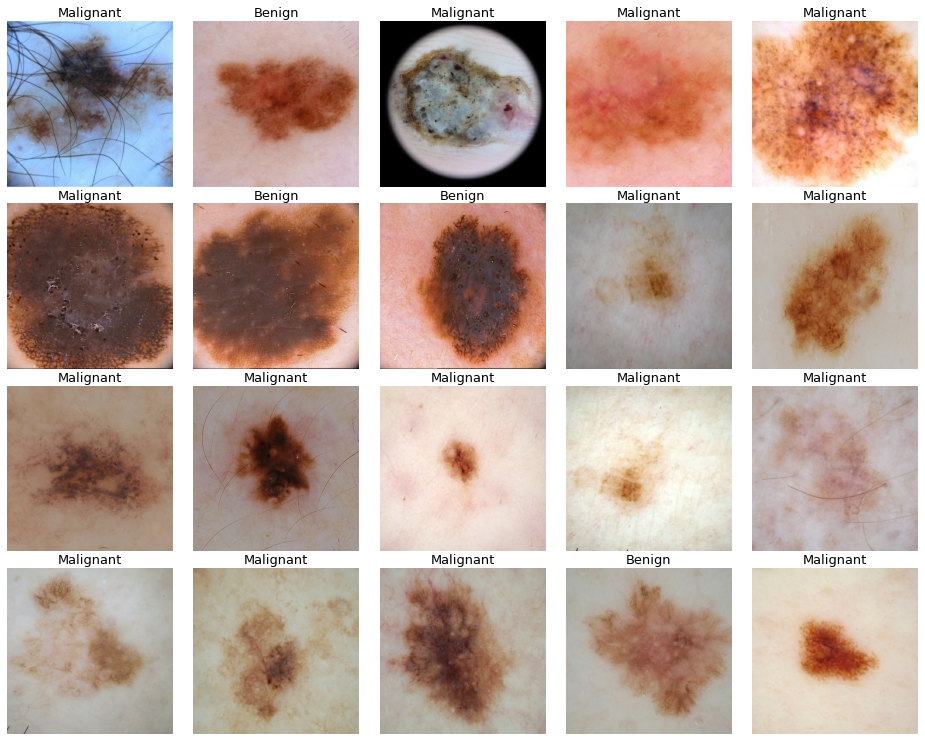

In [65]:
imgs_to_show = 20
display_batch_of_images((misclassified_images[0:imgs_to_show], misclassified_images_true_labels[0:imgs_to_show]), unbatched=True)

Max 0.853
Min 0.0207
Median 0.2771
Total misclassified 340
Misclassified malignant images 279
 


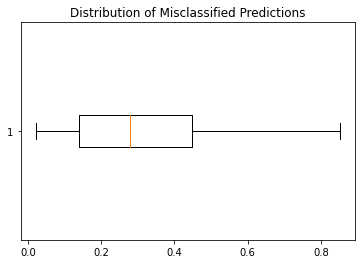

In [66]:
x = [x[0] for x in misclassified_predictions]
print("Max", round(np.max(x), 4))
print("Min", round(np.min(x), 4))
print("Median", round(np.median(x), 4))

print("Total misclassified", len(misclassified_images_true_labels))
print("Misclassified malignant images", sum(misclassified_images_true_labels))

print(" ")
_, ax1 = plt.subplots()
ax1.set_title('Distribution of Misclassified Predictions')
_ = ax1.boxplot(x, vert=False,)
plt.savefig(timestamp + '-misclassified_distribution.png')

# Ensemble Predictions

In [73]:
# helper function to create a csv file from the model predictions
def create_prediction_csv(labels, predictions, name):
    pred_csv = pd.DataFrame({
        'image_name': labels,
        'target': predictions
    })
    pred_csv.to_csv("./" + name + ".csv", index=False)

## Random Forest Data Preparation

In [117]:
df_test.shape

(10982, 7)

In [118]:
df_test.head(3)

image_name  patient_id  ... width  height
0  ISIC_0052060  IP_3579794  ...  6000    4000
1  ISIC_0052349  IP_7782715  ...  6000    4000
2  ISIC_0058510  IP_7960270  ...  6000    4000

[3 rows x 7 columns]

In [ ]:
labels = list(df_test['image_name'])

In [110]:
feature_columns = ['age_approx', 'sex_female', 'sex_male', 'anatom_head/neck',
       'anatom_lower extremity', 'anatom_oral/genital', 'anatom_palms/soles',
       'anatom_torso', 'anatom_upper extremity']

# getting dummy variables for gender
sex_dummies = pd.get_dummies(df_test['sex'], prefix='sex', dtype="int")
df_test = pd.concat([df_test, sex_dummies], axis=1)

# getting dummy variables for anatom_site_general_challenge
anatom_dummies = pd.get_dummies(df_test['anatom_site_general_challenge'], prefix='anatom', dtype="int")
df_test = pd.concat([df_test, anatom_dummies], axis=1)

# convert age to int
df_test['age_approx'] = df_test['age_approx'].astype('int')

# dropping not useful columns
df_test.drop(['sex','anatom_site_general_challenge', 'patient_id'], axis=1, inplace=True)

df_test = df_test[feature_columns]

df_test.head(1)

age_approx  sex_female  ...  anatom_torso  anatom_upper extremity
0          70           0  ...             0                       0

[1 rows x 9 columns]

In [115]:
meta_predictions = meta_model.predict_proba(df_test)
meta_predictions = [x[1] for x in meta_predictions]
meta_predictions[0:5]

[0.776021479474786,
 0.7170443908403339,
 0.7476212914915618,
 0.7476212914915618,
 0.7304797169675125]

In [122]:
create_prediction_csv(labels, meta_predictions, 'meta_predictions')

## CNNs

In [71]:
# load the sample submission file provided by the kaggle competition
submission_df = pd.read_csv('/content/melanoma-classification/data/sample_submission.csv')

In [72]:
# load the test dataset
test_dataset = get_test_dataset(ordered=True)
num_test_images = count_data_items(TEST_FILENAMES)

test_dataset_images = test_dataset.map(lambda image, image_name: image)
test_dataset_image_name = test_dataset.map(lambda image, image_name: image_name).unbatch()
test_ids = next(iter(test_dataset_image_name.batch(num_test_images))).numpy().astype('U')

In [74]:
# get the predictions from each model
for f in tqdm(glob.glob("/content/*.h5")):
    K.clear_session()
    model = tf.keras.models.load_model(f)
    model_name = f.replace("/content/", "").replace(".h5", "")
    model_predictions = model.predict(test_dataset_images, verbose=1, steps=math.ceil(len(test_ids) / BATCH_SIZE))
    model_predictions = [x[0] for x in list(model_predictions)]
    create_prediction_csv(test_ids, model_predictions, model_name)

  0%|          | 0/8 [00:00<?, ?it/s]

344/344 [==============================] - 199s 561ms/step


 12%|█▎        | 1/8 [03:30<24:34, 210.71s/it]

344/344 [==============================] - 111s 313ms/step


 25%|██▌       | 2/8 [06:04<19:21, 193.57s/it]

344/344 [==============================] - 111s 312ms/step


 38%|███▊      | 3/8 [08:03<14:15, 171.13s/it]

344/344 [==============================] - 69s 197ms/step


 50%|█████     | 4/8 [09:14<09:25, 141.28s/it]

344/344 [==============================] - 110s 312ms/step


 62%|██████▎   | 5/8 [11:13<06:43, 134.52s/it]

344/344 [==============================] - 145s 412ms/step


 75%|███████▌  | 6/8 [13:47<04:41, 140.50s/it]

344/344 [==============================] - 145s 410ms/step


 88%|████████▊ | 7/8 [16:23<02:24, 144.96s/it]

344/344 [==============================] - 145s 410ms/step


100%|██████████| 8/8 [18:57<00:00, 142.20s/it]


In [95]:
for f in glob.glob("/content/*.csv"):
    csv_prediction = pd.read_csv(f)
    break

csv_prediction.head()

image_name    target
0  ISIC_2272503  0.019831
1  ISIC_9821912  0.018906
2  ISIC_2077755  0.035922
3  ISIC_9350250  0.017112
4  ISIC_5800765  0.023134

In [76]:
len(glob.glob("/content/*.csv"))

8

In [168]:
all_predictions_df = submission_df.copy()
# drop the target column from the sample file
all_predictions_df = all_predictions_df.drop(columns=['target'])

for f in glob.glob("/content/*.csv"):
    # skip the sample submission file
    if f == "/content/submission.csv" or f == "/content/meta_predictions.csv":
        pass
    else:
        print("merge file", f)
        # now merge the dataframes together
        csv_prediction = pd.read_csv(f)
        all_predictions_df = all_predictions_df.merge(csv_prediction, on="image_name")

merge file /content/effnetB5-SEED0.csv
merge file /content/xception.csv
merge file /content/effnetB6-Seed21.csv
merge file /content/effnetB5-SEED42.csv
merge file /content/effnetB6-Seed42.csv
merge file /content/effnetB7.csv
merge file /content/effnetB6-Seed0.csv
merge file /content/effnetB5-SEED21.csv


In [169]:
all_predictions_df.head()

image_name  target_x  target_y  ...  target_y  target_x  target_y
0  ISIC_0052060  0.017623  0.030358  ...  0.023387  0.018421  0.022269
1  ISIC_0052349  0.027214  0.031327  ...  0.027234  0.023941  0.018499
2  ISIC_0058510  0.017892  0.030972  ...  0.022693  0.018978  0.020442
3  ISIC_0073313  0.025566  0.030912  ...  0.023168  0.023518  0.024415
4  ISIC_0073502  0.017892  0.030951  ...  0.026649  0.027515  0.022198

[5 rows x 9 columns]

In [175]:
# calculate the mean prediction value for each image
all_predictions_df["pred_mean"] = ""

for index, row in all_predictions_df.iterrows():
    pred_mean = 0
    # iterate over each column of each row
    for c in row:
        # pass the image name
        if isinstance(c, str):
            pass
        else:
            pred_mean = pred_mean + c

    # calculdate the mean
    pred_mean = pred_mean / (all_predictions_df.shape[1] - 2)
    all_predictions_df.at[index,'pred_mean'] = pred_mean

In [176]:
all_predictions_df.head()

image_name  target_x  target_y  ...  target_x  target_y  pred_mean
0  ISIC_0052060  0.017623  0.030358  ...  0.018421  0.022269  0.0225287
1  ISIC_0052349  0.027214  0.031327  ...  0.023941  0.018499  0.0384423
2  ISIC_0058510  0.017892  0.030972  ...  0.018978  0.020442  0.0223657
3  ISIC_0073313  0.025566  0.030912  ...  0.023518  0.024415  0.0263481
4  ISIC_0073502  0.017892  0.030951  ...  0.027515  0.022198  0.0279713

[5 rows x 10 columns]

In [177]:
ensemble_predictions = all_predictions_df[['image_name', 'pred_mean']]
ensemble_predictions = ensemble_predictions.rename({'pred_mean': 'target'}, axis='columns')

In [178]:
ensemble_predictions[0:3]

image_name     target
0  ISIC_0052060  0.0225287
1  ISIC_0052349  0.0384423
2  ISIC_0058510  0.0223657

In [179]:
sub_df = pd.DataFrame(ensemble_predictions, columns = ['image_name', 'target']) 

In [180]:
sub_df.head()

image_name     target
0  ISIC_0052060  0.0225287
1  ISIC_0052349  0.0384423
2  ISIC_0058510  0.0223657
3  ISIC_0073313  0.0263481
4  ISIC_0073502  0.0279713

In [181]:
sub_df['target'] = sub_df['target'].astype('float')
pd.Series(np.round(sub_df['target'].values)).value_counts()

0.0    10906
1.0       76
dtype: int64

# Submission

In [84]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/saschamet/master-thesis/5b50b23def4d47e291004183fcbd0d44
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgrad       : 1
COMET INFO:     Adam_beta_1        : 0.8999999761581421
COMET INFO:     Adam_beta_2        : 0.9990000128746033
COMET INFO:     Adam_decay         : 1
COMET INFO:     Adam_epsilon       : 1e-07
COMET INFO:     Adam_learning_rate : 4.0280001556425304e-09
COMET INFO:     Optimizer          : Adam
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: ---------------------------
COMET INFO: Uploading metrics, param

In [182]:
sub_df.to_csv("./submission.csv", index=False)
!kaggle competitions submit -c siim-isic-melanoma-classification -f submission.csv -m "Ensemble Predictions"

100% 359k/359k [00:00<00:00, 1.72MB/s]
Successfully submitted to SIIM-ISIC Melanoma Classification